# SMAI Assignment - 2

## Question - `2` : Face Recognition using Principal Component Analysis

| | |
|- | -|
| Course | Statistical Methods in AI |
| Release Date | `16.02.2023` |
| Due Date | `24.02.2023` |

### <b>Objective:</b>
This question requires you to create a basic facial recognition system using a technique called principal component analysis (PCA) 
by projecting the face images on the feature space (face space) which best
represents the variations among distinct faces. The face space is defined as the
“Eigenfaces", which are the eigenvectors of the set of faces.

The goal of implementing this system is to recognize a person's face by comparing it to a pre-existing database of faces, and identifying the closest match.

Link to paper on Eigenfaces: [https://sites.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf](https://sites.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf)

### <b>About the dataset:</b>  
The AT&T face dataset contains a set of grayscale face images with dimensions 92x112. The images are organised in 40 directories (one for each subject), which have names of the form sX, where X indicates the subject number (between 1 and 40). In each of these directories, there are ten different images of that subject, which have names of the form Y.pgm, where Y is the image number for that subject (between 1 and 10). These 10 images per person are taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement). <b>Link:</b> [https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/](https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/)



### Tasks
1. Load dataset and divide the date into training and test sets. 
2. Implement the PCA algorithm from scratch.
3. Implement image reconstruction using the eigen projections and visualise differences for different number of components.
4. Visualise the mean(Eigen face) generated.
5. Given training set, obtain accuracy by attempting a face regonition module and obtaining the accuracy for different number of principal components.


#### Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import cv2
from copy import copy

#### Import Dataset
Assign labels for the images based on the subdirectories to obtain X(images array) and y (labels).

Ensure that the test data contains atleast one image from each category.

In [2]:
# iterate through all folders, load each image

trainAmt = 0.9
allFaces = []       # array of cv2 images
labels = []

for i in range(1,41):
    for j in range(1,11):
        imgPath = os.path.join("ATnT", "s" + str(i), str(j) + ".pgm")
        img = cv2.imread(imgPath, -1)

        allFaces.append(img)
        labels.append(i)

# shuffle
randomOrder = np.random.permutation(len(labels))
allFaces = np.array(allFaces)[randomOrder]
labels = np.array(labels)[randomOrder]

# split
trainFaces = allFaces[:int(trainAmt*len(allFaces))]
trainLabels = labels[:int(trainAmt*len(allFaces))]

testFaces = allFaces[int(trainAmt*len(allFaces)): ]
testLabels = labels[:int(trainAmt*len(allFaces))]

# 112x92 (= 10304) grayscale images,  360 in train, 40 in test
print(trainFaces.shape, trainLabels.shape)

(360, 112, 92) (360,)


#### Implement PCA Algorithm.

Treating each pixel as a feature results in a (w\*h)x(w\*h) covariance matrix. Finding the eigenvalues/vectors for this matrix is not even feasible (I even tried with cuda).
But since we just have 400 images which is << than the number of features, there will only be 400 meaningful eignenvectors


If $A^TA \bold{v}_{\textit{i}} = \mu_{\textit{i}}\bold{v}_{\textit{i}}$, 
<br>pre-multiply A to get<br>
$AA^TA \bold{v}_{\textit{i}} = \mu_{\textit{i}}A\bold{v}_{\textit{i}}$, 

Thus, $A\bold{v}_{\textit{i}}$ is an eigenvalue for $AA^T$ for all $\textit{i}$

Instead of decomposing $AA^T$, we decompose $A^TA$ instead. $A\bold{v}_{\textit{i}}$ describes a linear combination of faces that can produce any face in face-space

In [110]:
"""
Implement pca in the following function by taking the following arguements:
1. X(images array)
2. number of components
The function must return the eigen vectors (principal components) also termed "Eigen faces"
"""

%matplotlib inline

def principalComponentAnalysis(x, numComponents=50):
    numImages = x.shape[0]

    # normalise data, (subtract avg face)
    imgVectors = (x.reshape(numImages, -1)).astype(np.float64)
    psi = np.mean(imgVectors, axis=0).astype(np.float64)     # aka meanFace

    # sigma = np.sum(np.square((imgVectors - mu).astype(np.float64)), axis=0)/imgVectors.shape[0]
    # sigma = np.sqrt(sigma)

    nImgVectors = imgVectors - psi       # aka Phi

    print(nImgVectors.shape)
    # # nImgVectors /= sigma
    
    # generate a covariance matrix and eigen values
    print("Generating covariance matrix...")
    L = nImgVectors@nImgVectors.T
    print(L.shape)
    # L = np.zeros((numImages, numImages), dtype=np.float64)
    # for n in range(numImages):
    #     print(np.outer(nImgVectors[n], nImgVectors[n]).shape)
    #     L += (nImgVectors[n]@nImgVectors[n].T)     # AT A in the paper

    print("Generating eigenfaces...")
    eigenvalues, eigenvectors = np.linalg.eigh(L)   # 360 eigenvalues/vectors
    order = np.argsort(-eigenvalues)
    eigenvalues = eigenvalues[order]
    eigenvectors = eigenvectors.T[order]


    print(eigenvectors)

    # # print((cov)@eigenvectors[:,-1] - eigenvalues[-1]*eigenvectors[:,-1])

    eigenfaces = (eigenvectors@nImgVectors)

    print(eigenfaces.shape)


    return eigenfaces[:numComponents], psi

(360, 10304)
Generating covariance matrix...
(360, 360)
Generating eigenfaces...
[[ 7.10555596e-02  1.27875623e-02  3.42131748e-02 ... -5.03911240e-02
   6.04420428e-02 -4.24364898e-03]
 [ 3.79280551e-02 -2.14005329e-02  3.37819478e-02 ...  5.15577101e-02
  -4.73986175e-02  2.38656878e-02]
 [-6.16610640e-02  7.69829573e-02  9.48702142e-02 ... -1.55434941e-02
   7.73702687e-02 -4.98497244e-03]
 ...
 [-2.96925687e-03 -2.69761258e-02  3.63353306e-01 ... -2.21542129e-02
   1.46415734e-02 -2.65137311e-03]
 [ 6.56977519e-03 -1.18219154e-03 -1.08240580e-01 ...  3.69429202e-02
   1.93502758e-02  3.52844415e-04]
 [ 5.27046277e-02  5.27046277e-02  5.27046277e-02 ...  5.27046277e-02
   5.27046277e-02  5.27046277e-02]]
(360, 10304)


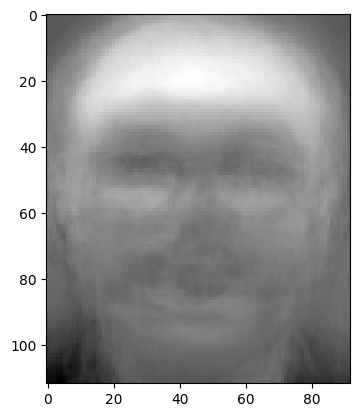

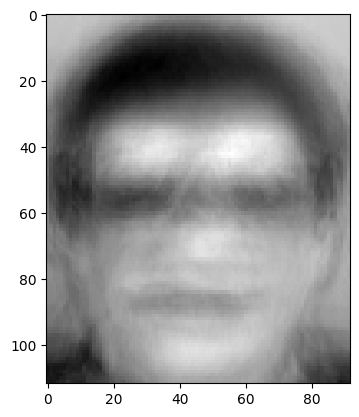

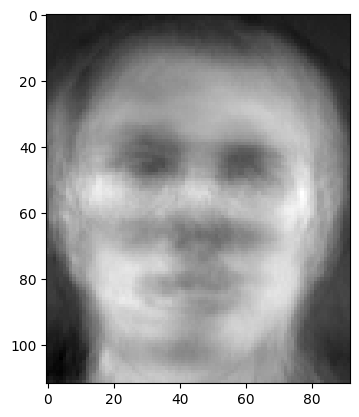

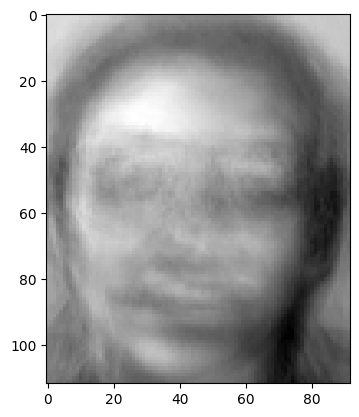

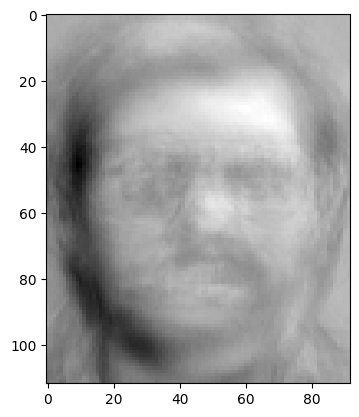

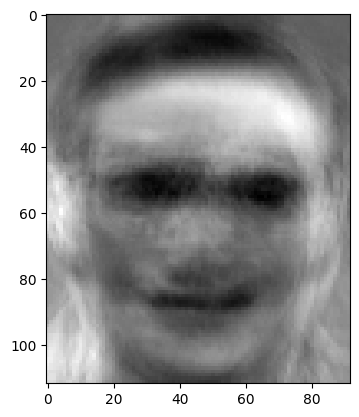

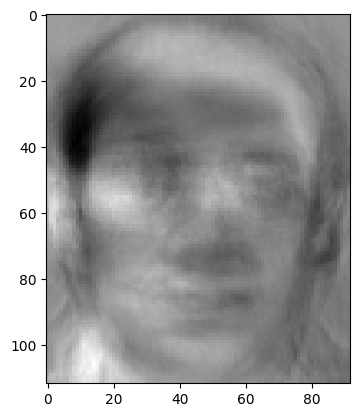

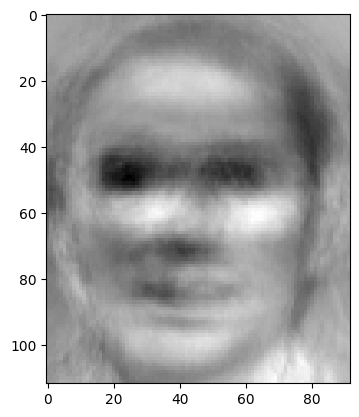

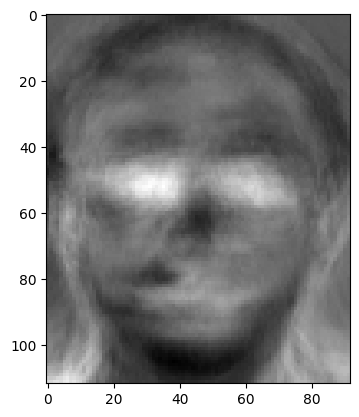

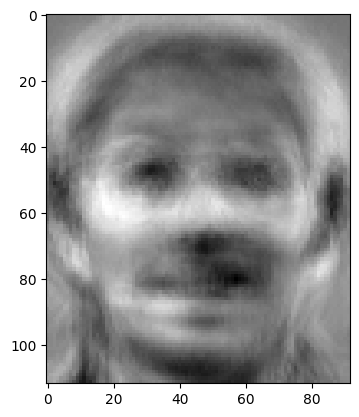

In [111]:
eigenfaces, meanFace = principalComponentAnalysis(trainFaces, 360)
%matplotlib inline
for i in eigenfaces[:10]:
    plt.imshow(i.reshape(112,92), cmap='gray')
    plt.show()

#### Implement Image Reconstruction from Eigenfaces


Explain your steps with comments and write a brief explanation of the method.

In [131]:
%matplotlib inline

# Function to implement image reconstruction by taking arguements as necessary.
def imageReconstruction(testFace, eigenfaces, meanFace):
    reconstructedFace = np.zeros_like(testFace, dtype=np.float64)

    print(eigenfaces.shape, eigenfaces[0].shape)

    for wi in eigenfaces:
        reconstructedFace += ((wi.T@(testFace - meanFace)) * wi)/np.linalg.norm(wi)
        # plt.imshow(((wi.T@(testFace - meanFace)) * wi).reshape(112,92), cmap='gray')
        # plt.show()
    

    # reconstructedFace /= np.max(reconstructedFace)
    # meanFace /= np.max(meanFace)
    print("Test: ", testFace[:10], "\nMean: ", meanFace[:10],'\nRec: ', reconstructedFace[:10]/10000)
    plt.imshow((reconstructedFace/18000 + meanFace).reshape(112,92), cmap='gray')
    plt.show()
    plt.imshow((reconstructedFace).reshape(112,92), cmap='gray')
    plt.show()

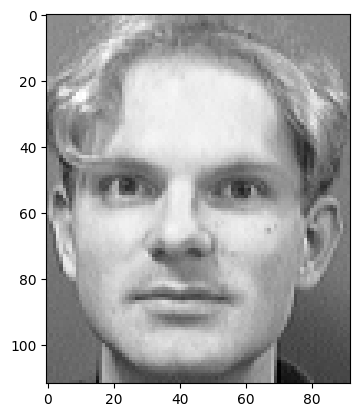

(360, 10304) (10304,)
Test:  [121 120 122 119 119 120 119 119 121 116] 
Mean:  [85.35       85.225      85.55833333 85.475      85.51388889 85.825
 85.65555556 85.48611111 85.725      85.675     ] 
Rec:  [73.39965153 73.80638204 73.89803793 71.77743702 73.24061408 74.28155573
 77.63151248 77.15034669 75.97032785 77.68302341]


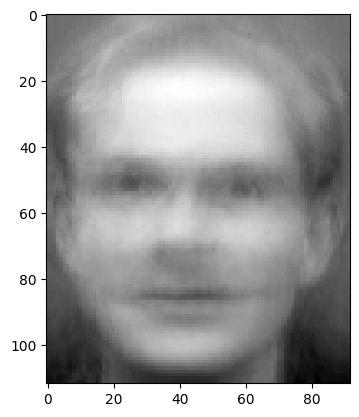

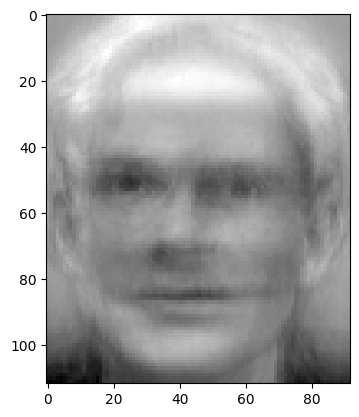

In [133]:
%matplotlib inline
plt.imshow(trainFaces[0].reshape(112,92), cmap='gray')
plt.show()
imageReconstruction(trainFaces[0].reshape(-1), eigenfaces, meanFace)

#### Visualisation
Visualise the results for different number of principal components(pc = 5,10,100, 1000, all).

**Note:** Ensure that the images are labelled appropriately.

#### Implement face recognition module based on the norm
Explain your steps with comments and write a brief explanation of the method.

*   Test the module and report accuracies based on the number of components taken for a range of value and plot them. 
*   Also plot the mean square error vs the number of eigenvectors taken and report your observations. 
*   For further empirical analysis, plot the semi-log variant of the error plot obtained above.

In [ ]:
"""
Implement pca in the following function by taking the following arguements:
1. Test image
2. Eigenvectors
3. Mean Eigen Face
4. Training Set(X_train,y_train)
The function must return the following:
1. image with smallest error
2. error value
3. prediction class
"""
def model():

  return

In [ ]:
"""
Iterate through all the images in the test data and 
test the accurate by taking different number of components
"""

In [ ]:
# Plot Number of eigenvectors vs Mean Square Error

In [ ]:
# Plot Number of eigenvectors vs Logarithmic Mean Square Error

Summarise your observations on the plots and accuracies

**Answer:**

State the advantages and limitations of using PCA in general. Also state its limitations in context of face recognition

**Answer:**